In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import tensorflow as tf 

tf.__version__

'2.2.0-rc3'

In [0]:
train_df = pd.read_csv("/content/drive/My Drive/Twitter_project/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Twitter_project/test.csv")

In [0]:
# Normalization
import re
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df
data_clean = clean_text(train_df, 'text', 'text_clean')
data_clean.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [0]:
# Création d'un tf dataset à partir de pandas 
tf_train = tf.data.Dataset.from_tensor_slices((train_df["text_clean"].values, train_df["target"].values))

In [0]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [0]:
corpus = "|".join(train_df["text_clean"].to_list())

In [0]:
%%time
import time
nlp.max_length = len(corpus)
doc = nlp(corpus)

CPU times: user 15.8 s, sys: 1.03 s, total: 16.8 s
Wall time: 16.8 s


In [0]:
# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS

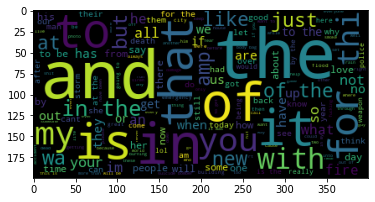

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wd = WordCloud(stopwords=STOP_WORDS)
cloud = wd.generate(doc.text)
plt.imshow(cloud)

In [0]:
%%time
tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
vocabulary_set= set(tokens)
vocab_size = len(vocabulary_set)
print(vocab_size)

16299
CPU times: user 154 ms, sys: 845 µs, total: 154 ms
Wall time: 157 ms


In [0]:
# Création d'un nombre pour chacun des tokens que nous avons créés au dessus
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [0]:
# Regardons le résultat sur un exemple 
for example, _ in tf_train.take(1):
  print(encoder.encode(example.numpy()))
  print(example.numpy())

[16300, 16300, 16300, 9077, 5561, 6987, 6417, 5896, 5357, 1737, 4548, 14611, 15877]
b'our deeds are the reason of this earthquake may allah forgive us all'


In [0]:
# Encodons maintenant tous les éléments d'un dataset
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

# Utilisation du fonction py_function pour encoder tout le dataset 
def encode_map_fn(text, label):
  return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

all_encoded_data = tf_train.map(encode_map_fn)

In [0]:
# Train Test Split
TAKE_SIZE = int(0.7*train_df.shape[0])

train_data = all_encoded_data.take(TAKE_SIZE).shuffle(50000)
train_data = train_data.padded_batch(16,  padded_shapes=([-1], []))

test_data = all_encoded_data.skip(TAKE_SIZE)
test_data = test_data.padded_batch(16, padded_shapes=([-1], []))

In [0]:
 # Regardons un batch 
for review, star in train_data.take(1):
  print(review, star)

tf.Tensor(
[[10650 16300 16300  4000  1433 16300 11572 16300 15048 13124  2894 12755
      0     0     0     0     0     0     0     0     0     0]
 [14904 14142  7838 16300  2522 10625  1113 13116     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [ 1737 16300 16300  4446  4021  3929 16300  1206 11792  2779 16300  9077
   3011  6987  9077  6775  6987 11166 12262  4525  3697  6731]
 [16300  5262 16300  8191   271  9077 14647 10375  8253  1492  3448     0
      0     0     0     0     0     0     0     0     0     0]
 [16300  6444  6347   933  7764 15941 12553 16300 10635 16300 16300     0
      0     0     0     0     0     0     0     0     0     0]
 [16300 16300  8738  7258  8783  9834 12608 12858 10322     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [12513 15065  2563 16300   892  5475 16300 15249 16285   271 16300  3514
  16300 12905   271 16300  8575 12206  6117 16300     0     0]
 [16300     0     0     0     

In [0]:
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(encoder.vocab_size, 64),

                  # Couche LSTM Bidirectionnelle
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

                  # Couche CNN
                  tf.keras.layers.Conv1D(16, 3, activation="relu"),
                  
                  # Nouvelle couche LSTM Bidirectionnel
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                  # Nouvelle couche LSTM
                  tf.keras.layers.LSTM(32, return_sequences=False),               

                  # Couche Dense classique 
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
                                              
])

In [0]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2500,
    decay_rate=0.96,
    staircase=True)

# Utilisation d'un compileur simple avec un optimiseur Adam pour le calcul de nos gradients 
optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

# Création d'un compileur
model.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss= tf.keras.losses.binary_crossentropy,
              metrics = [tf.keras.metrics.binary_accuracy])

In [0]:
# Application du modèle sur 20 epochs
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=40)

Epoch 1/40
334/334 [==============================] - 25s 75ms/step - loss: 0.6774 - binary_accuracy: 0.5793 - val_loss: 0.6266 - val_binary_accuracy: 0.6589
Epoch 2/40
334/334 [==============================] - 25s 73ms/step - loss: 0.5064 - binary_accuracy: 0.7814 - val_loss: 0.5285 - val_binary_accuracy: 0.7452
Epoch 3/40
334/334 [==============================] - 25s 74ms/step - loss: 0.3734 - binary_accuracy: 0.8512 - val_loss: 0.5268 - val_binary_accuracy: 0.7570
Epoch 4/40
334/334 [==============================] - 24s 73ms/step - loss: 0.2961 - binary_accuracy: 0.8893 - val_loss: 0.5491 - val_binary_accuracy: 0.7474
Epoch 5/40
334/334 [==============================] - 25s 73ms/step - loss: 0.2409 - binary_accuracy: 0.9161 - val_loss: 0.6447 - val_binary_accuracy: 0.7347
Epoch 6/40
334/334 [==============================] - 24s 73ms/step - loss: 0.2027 - binary_accuracy: 0.9309 - val_loss: 0.7525 - val_binary_accuracy: 0.7237
Epoch 7/40
334/334 [==============================] 

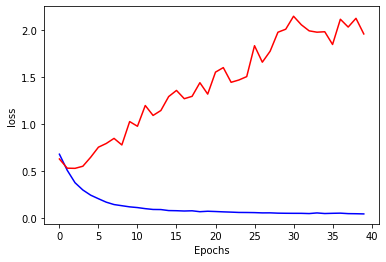

In [0]:
import matplotlib.pyplot as plt

# Visualisation du processus d'entrainement sur la loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [0]:
history.history

{'binary_accuracy': [0.5792831778526306,
  0.7813848853111267,
  0.8511915802955627,
  0.8892850279808044,
  0.9161193370819092,
  0.9309439063072205,
  0.9453931450843811,
  0.9530869126319885,
  0.9583411812782288,
  0.9602176547050476,
  0.9641583561897278,
  0.9675361514091492,
  0.9703509211540222,
  0.9714768528938293,
  0.9726027250289917,
  0.9739162921905518,
  0.9741039872169495,
  0.974854588508606,
  0.976168155670166,
  0.9746668934822083,
  0.9739162921905518,
  0.9739162921905518,
  0.9744792580604553,
  0.9742916226387024,
  0.9756051898002625,
  0.976355791091919,
  0.977669358253479,
  0.9754175543785095,
  0.9778569936752319,
  0.9780446887016296,
  0.9795458912849426,
  0.9787952899932861,
  0.9786075949668884,
  0.9774817228317261,
  0.9793582558631897,
  0.9780446887016296,
  0.9784199595451355,
  0.9789829254150391,
  0.979170560836792,
  0.9812347292900085],
 'loss': [0.6774015426635742,
  0.5063549280166626,
  0.37344619631767273,
  0.29612165689468384,
  0.240

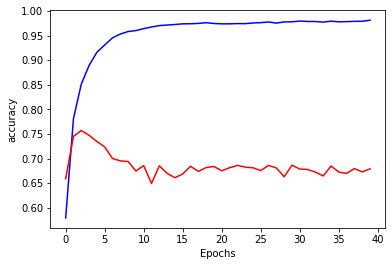

In [0]:
# Visualisation de l'entrainement sur l'accuracy 
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()